In [324]:
import numpy as np
from sklearn.datasets import load_breast_cancer 
from graphviz import Digraph

# Data

In [325]:
data = load_breast_cancer()
X = data.data
y = data.target

# bootstrap function

In [326]:
def bootstrap_sample(X, y):
    n_sample  = X.shape[0]
    index = np.random.default_rng().choice(n_sample , size = n_sample , replace = True)
    return X[index] , y[index]

# Decision tree class

In [327]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def __init__(self, max_depth = None, min_sample_split :int = None, n_features = None):
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.n_features = n_features
        self.root = None

    def entropy(self,y):
        cls, counts = np.unique(y , return_counts = True)
        p = [i / len(y) for i in counts]
        entropy = -np.sum(p * np.emath.log2(p))
        return entropy

    def info_gain(self, X, y):

        features = X.shape[1]
        
        if self.n_features is not None:
            feat_idx = np.random.default_rng().choice(np.arange(features), size = self.n_features)
        else:
            feat_idx = range(features)    
        
        best_ig = 0
        best_threshold = None
        best_feature = None

        for i in feat_idx:
            unique_vals = np.sort(np.unique(X[: , i]))
            thresholds = (unique_vals[1:] + unique_vals[: -1]) / 2
            for thres in thresholds:
                left_mask = X[:, i] <= thres
                right_mask = X[:, i] > thres

                y_left = y[left_mask]
                y_right = y[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                ig = self.entropy(y) - (((len(y_left)  / len(y)) * self.entropy(y_left)) + ((len(y_right)  / len(y)) * self.entropy(y_right)))

                if ig > best_ig:
                    best_ig = ig
                    best_threshold = thres
                    best_feature = i

        
        return best_ig, best_feature, best_threshold

    def build_tree(self, X, y, depth = 0):
        if len(np.unique(y)) == 1:
            return Node(value = y[0])
            
        if self.max_depth is not None and depth >= self.max_depth:
            return Node(value = np.bincount(y).argmax())

        if self.min_sample_split is not None and len(y) < self.min_sample_split:
            return Node(value=np.bincount(y).argmax())
        
        ig, feature, threshold = self.info_gain(X,y)
        if ig ==0:
            return Node(value = np.bincount(y).argmax())

        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold

        X_left , y_left = X[left_mask] , y[left_mask]
        X_right , y_right = X[right_mask] , y[right_mask]

        left_node = self.build_tree(X_left, y_left, depth + 1)
        right_node = self.build_tree(X_right, y_right, depth + 1)

        return Node(
            feature = feature,
            threshold = threshold,
            left = left_node,
            right = right_node
        )
        

    def fit(self, X, y):
        self.root =  self.build_tree(X, y, depth = 0)

    def plot(self, node, dot, depth = None):
        if depth is None:
            depth = [0]
            
        dot.attr('node' , shape = 'box')
        current_id = str(depth[0])
        depth[0] += 1
    
        if node.value is not None:
            dot.node(current_id , f'Leaf \n Value: {node.value}')

        else: 
            dot.node(current_id, f'X[{node.feature}] <= {node.threshold:.2f}')
            left_id = self.plot(node.left,dot,  depth)
            right_id = self.plot(node.right,dot, depth)

            dot.edge(current_id, left_id, label='True')
            dot.edge(current_id, right_id, label='False')

        return current_id
    
    def _traverse_tree(self, X, node):
        if node.value is not None:
            return node.value

        if X[node.feature] <= node.threshold:
            return self._traverse_tree(X, node.left)
        else:
            return self._traverse_tree(X, node.right)

    def predict_one(self, X):
        return self._traverse_tree(X, self.root)
        
    def predict(self, X):
        return np.array([self.predict_one(i) for i in X])
        


# Random forest class

In [328]:
class RandomForest:
    def __init__(self, n_iter = 10, max_depth = 6, min_sample_split = 2, max_feature = None):
        self.n_iter = n_iter
        self.max_depth = max_depth
        self.min_sample_split = min_sample_split
        self.max_feature = max_feature
        self.trees = []

    def fit(self, X, y):
        
        if self.max_feature is None:
            self.max_feature = int(np.sqrt(X.shape[1]))
        
        for _ in range(self.n_iter):
            tree = DecisionTree(
                max_depth = self.max_depth,
                min_sample_split = self.min_sample_split,
                n_features = self.max_feature
            )

            # bootstrap the data
            X_sample, y_sample = bootstrap_sample(X, y)
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        tree_pred = np.array([tree.predict(X) for tree in self.trees])
        y_pred = []
        for i in range(tree_pred.shape[1]):
            label, count = np.unique(tree_pred[:, i], return_counts = True)
            majority_label = label[np.argmax(count)]
            y_pred.append(majority_label)
            
        return np.array(y_pred)
        
    

# Utility functions

In [329]:
def train_test_split(X, y, ratio, shuffle = False, seed = False):
    if seed:
        np.random.seed(seed)
    if shuffle:
        index = np.arange(len(X))
        np.random.shuffle(index)
        X, y = X[index], y[index]
    divider = int(len(X) * ratio)
    train_X = X[: divider]
    test_X = X[divider: ]
    train_y = y[: divider]
    test_y = y[divider: ]
    return train_X, train_y, test_X, test_y

def accuracy(y_true, y_pred):
        return np.sum(y_true == y_pred) / len(y_true)

# Model execution

In [330]:
train_X, train_y, test_X, test_y = train_test_split(X, y,ratio = 0.6 , shuffle = True , seed = 1)

model = RandomForest()
model.fit(train_X, train_y)
y_pred = model.predict(test_X)
print(f'Accuracy score: {accuracy(test_y, y_pred)}')

Accuracy score: 0.9692982456140351


# some examples of trees inside of random forest

tree no. 1


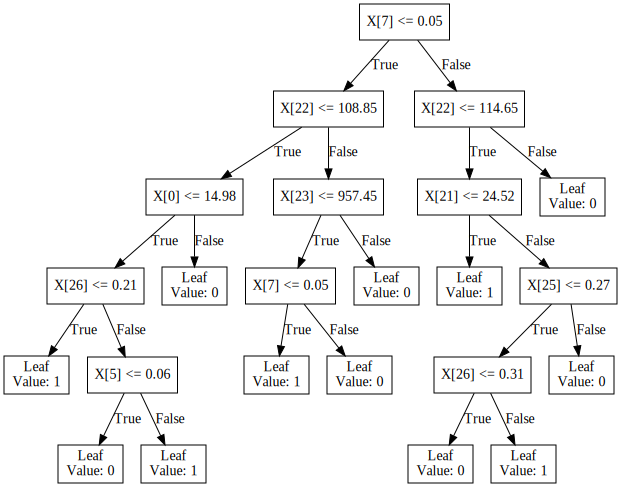

In [331]:
trees = model.trees
dot = Digraph()
tree_1 = trees[0].plot(trees[0].root, dot)
print('tree no. 1')
dot

tree no. 4


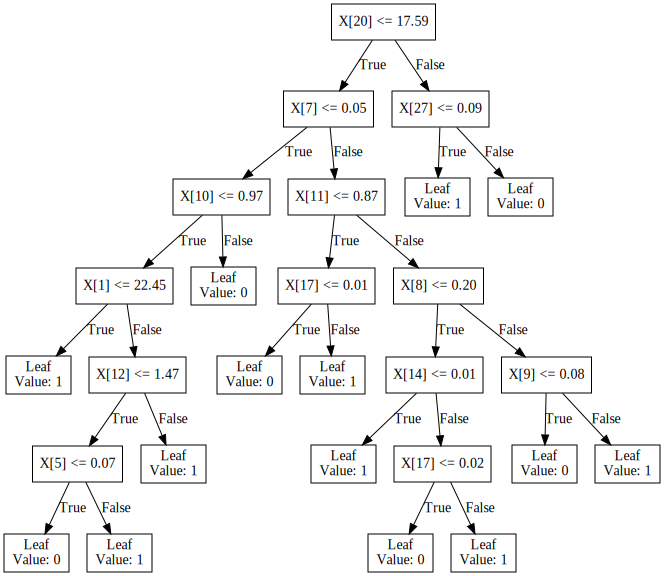

In [332]:
dot = Digraph()
tree_1 = trees[3].plot(trees[3].root, dot)
print('tree no. 4')
dot

tree no. 6


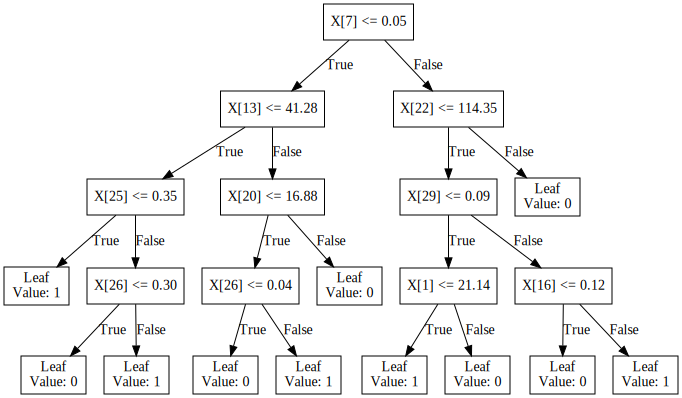

In [333]:
dot = Digraph()
tree_1 = trees[5].plot(trees[5].root, dot)
print('tree no. 6')
dot